In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time

In [2]:
RESULTS_PATH = os.path.join("benchmark", "results", "results.csv")

In [3]:
df = pd.read_csv(RESULTS_PATH)
df['version'].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       16, 17, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70])

In [4]:
# TEST min_sim_db
versions = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
df_min_sim_db = df[df['version'].isin(versions)]
df_min_sim_db.sort_values('min_sim_db', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_21352\1836878802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_sim_db.sort_values('min_sim_db', inplace=True)


In [5]:
columns = [
    'min_sim_db', 'keep_full_img', 
    'map_easy', 'map_medium', 'map_hard', 
    'mp@1_easy', 'mp@1_medium', 'mp@1_hard', 
    'mp@5_easy', 'mp@5_medium', 'mp@5_hard', 
    'mp@10_easy', 'mp@10_medium', 'mp@10_hard',
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox'
]
df_min_sim_db = df_min_sim_db[columns]

In [6]:
# Paso 1: separar por valor de keep_full_img
df_0 = df_min_sim_db[df_min_sim_db['keep_full_img'] == 0].copy()
df_1 = df_min_sim_db[df_min_sim_db['keep_full_img'] == 1].copy()

# Paso 2: renombrar columnas métricas en df_1
metric_cols = [col for col in df.columns if col not in ['min_sim_db', 'keep_full_img']]
df_1 = df_1.rename(columns={col: f"{col}_keep_full" for col in metric_cols})

# Paso 3: hacer merge por min_sim_db
df_min_sim_db_merged = pd.merge(df_0, df_1, on='min_sim_db', how='outer')

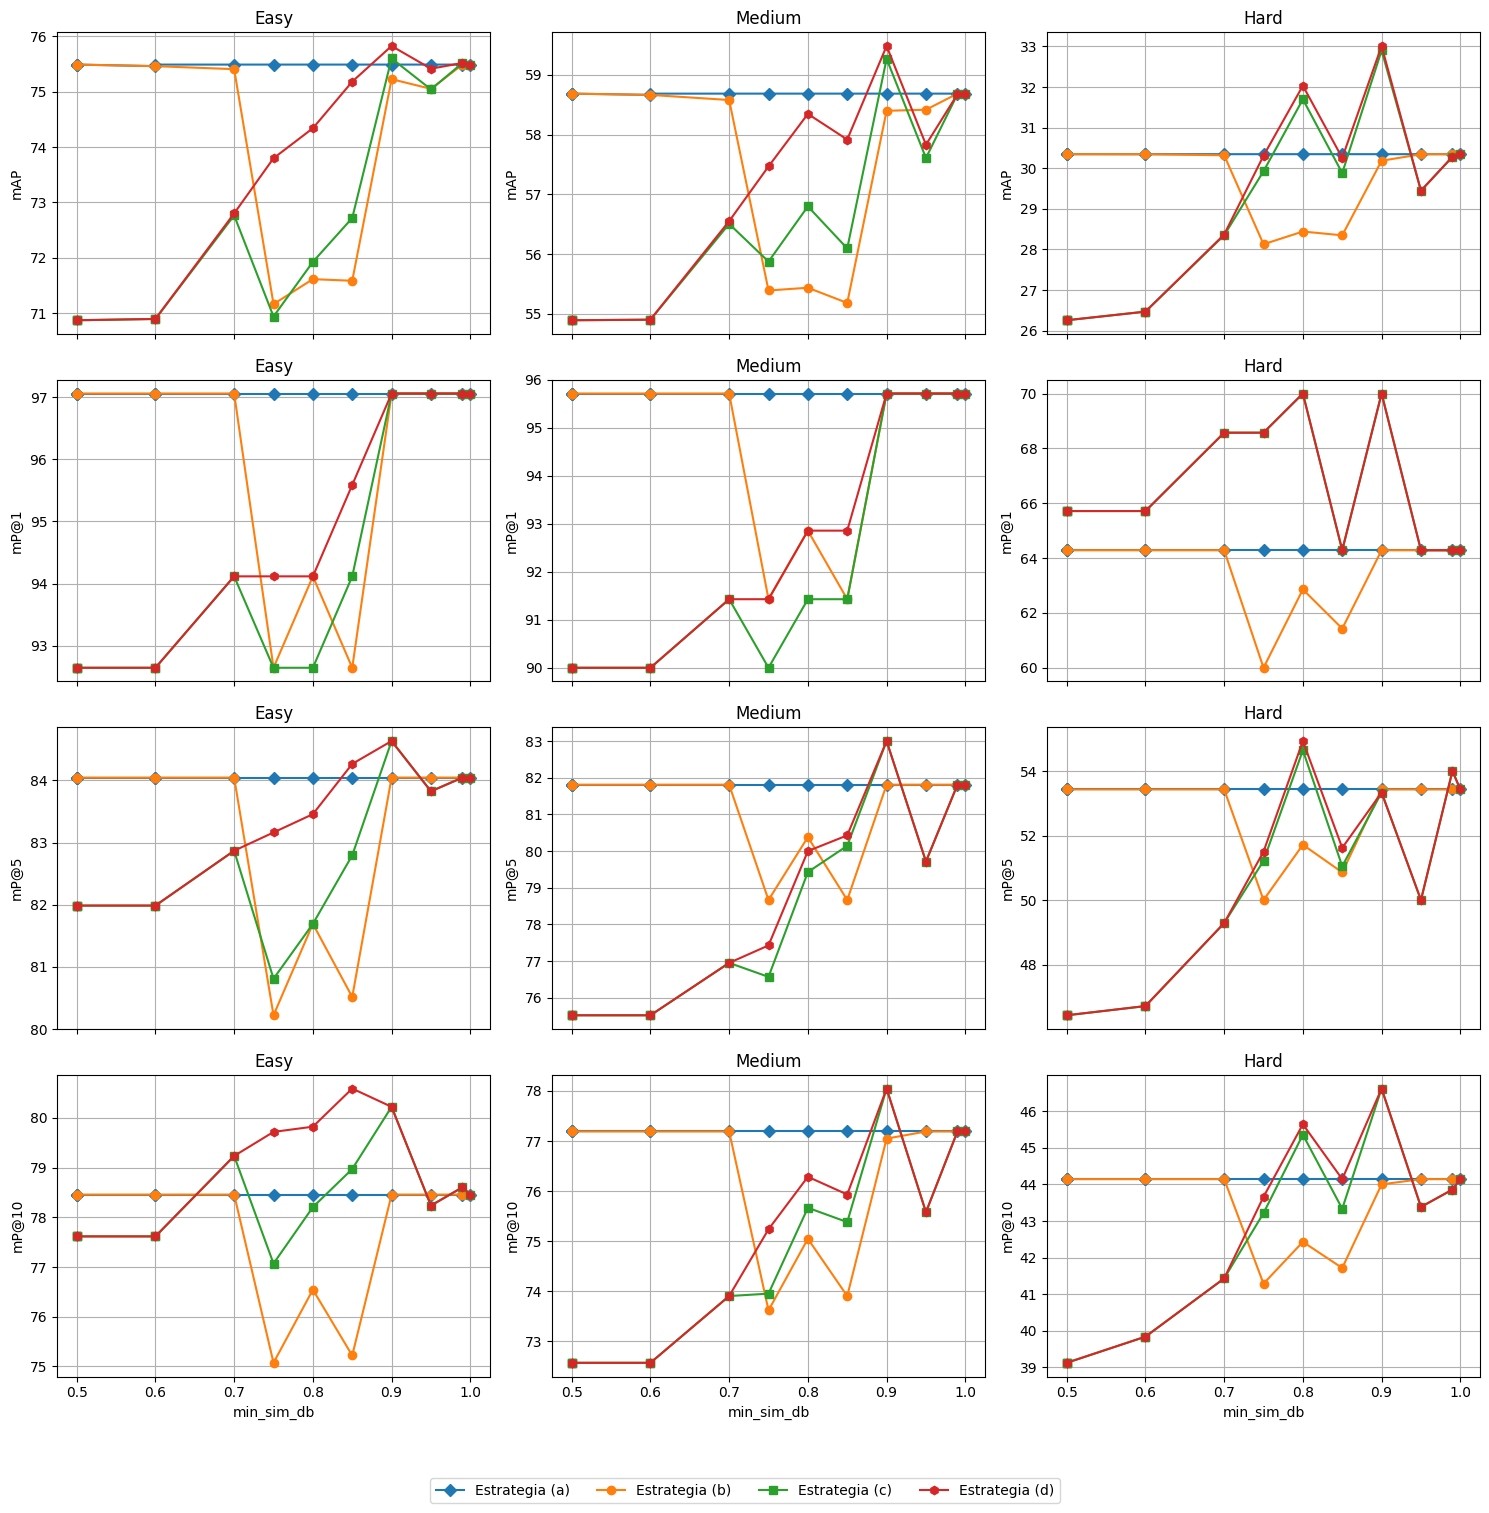

In [7]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy', 'map_easy_bbox', 'map_easy_keep_full', 'map_easy_bbox_keep_full', 'Easy'),
    ('map_medium', 'map_medium_bbox', 'map_medium_keep_full', 'map_medium_bbox_keep_full', 'Medium'),
    ('map_hard', 'map_hard_bbox', 'map_hard_keep_full', 'map_hard_bbox_keep_full', 'Hard'),
    ('mp@1_easy', 'mp@1_easy_bbox', 'mp@1_easy_keep_full', 'mp@1_easy_bbox_keep_full', 'Easy'),
    ('mp@1_medium', 'mp@1_medium_bbox', 'mp@1_medium_keep_full', 'mp@1_medium_bbox_keep_full', 'Medium'),
    ('mp@1_hard', 'mp@1_hard_bbox', 'mp@1_hard_keep_full', 'mp@1_hard_bbox_keep_full', 'Hard'),
    ('mp@5_easy', 'mp@5_easy_bbox', 'mp@5_easy_keep_full', 'mp@5_easy_bbox_keep_full', 'Easy'),
    ('mp@5_medium', 'mp@5_medium_bbox', 'mp@5_medium_keep_full', 'mp@5_medium_bbox_keep_full', 'Medium'),
    ('mp@5_hard', 'mp@5_hard_bbox', 'mp@5_hard_keep_full', 'mp@5_hard_bbox_keep_full', 'Hard'),
    ('mp@10_easy', 'mp@10_easy_bbox', 'mp@10_easy_keep_full', 'mp@10_easy_bbox_keep_full', 'Easy'),
    ('mp@10_medium', 'mp@10_medium_bbox', 'mp@10_medium_keep_full', 'mp@10_medium_bbox_keep_full', 'Medium'),
    ('mp@10_hard', 'mp@10_hard_bbox', 'mp@10_hard_keep_full', 'mp@10_hard_bbox_keep_full', 'Hard')
]

# Crear subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True, sharey=False)

for i, (ax, (col1, col2, col3, col4, title)) in enumerate(zip(axs.flat, metrics)):
    df_min_sim_db_merged.plot(x='min_sim_db', y=col3, ax=ax, label='Estrategia (a)', marker='D', legend=False)
    df_min_sim_db_merged.plot(x='min_sim_db', y=col1, ax=ax, label='Estrategia (b)', marker='o', legend=False)
    df_min_sim_db_merged.plot(x='min_sim_db', y=col2, ax=ax, label='Estrategia (c)', marker='s', legend=False)
    df_min_sim_db_merged.plot(x='min_sim_db', y=col4, ax=ax, label='Estrategia (d)', marker='h', legend=False)
    ax.set_title(title)
    ax.set_xlabel('min_sim_db')
    if i < 3:
        ax.set_ylabel('mAP')
    elif i < 6:
        ax.set_ylabel('mP@1')
    elif i < 9:
        ax.set_ylabel('mP@5')
    else:
        ax.set_ylabel('mP@10')
    ax.grid(True)

# Obtener handles y labels de cualquier eje (todos tienen los mismos)
handles, labels = axs[0, 0].get_legend_handles_labels()

# Colocar la leyenda una vez fuera del grid
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))

# plt.suptitle('Similitud mínima para la base de datos', fontsize=16, y=1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Guardar como imagen PNG (puedes cambiar el nombre o ruta si deseas)
plt.savefig('min_sim_db_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
# TEST min_area
versions = [22, 27, 28, 31, 32, 35, 36, 38, 39, 40, 41, 43]
df_min_area = df[df['version'].isin(versions)]
df_min_area.sort_values('min_area', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_21352\4186622158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_area.sort_values('min_area', inplace=True)


In [9]:
columns = [
    'version',
    'min_area', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox'
]
df_min_area = df_min_area[columns]

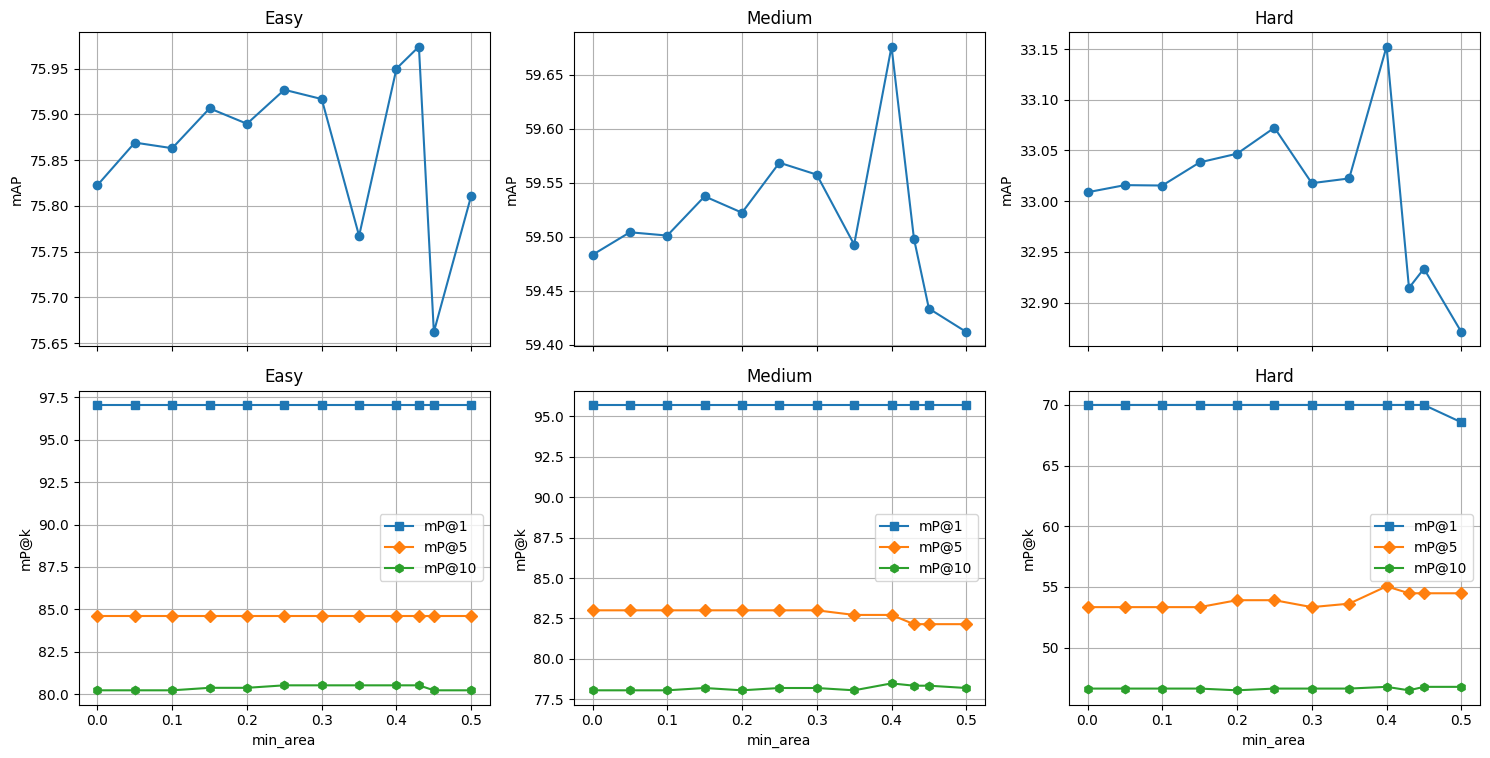

In [10]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'Hard'),
    ('mp@1_easy_bbox', 'Easy'),
    ('mp@1_medium_bbox', 'Medium'),
    ('mp@1_hard_bbox', 'Hard'),
    ('mp@5_easy_bbox', 'Easy'),
    ('mp@5_medium_bbox', 'Medium'),
    ('mp@5_hard_bbox', 'Hard'),
    ('mp@10_easy_bbox', 'Easy'),
    ('mp@10_medium_bbox', 'Medium'),
    ('mp@10_hard_bbox', 'Hard')
]
metrics = [
    ('map_easy_bbox', 'map_easy_bbox', 'map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'map_medium_bbox', 'map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'map_hard_bbox', 'map_hard_bbox', 'Hard'),
    ('mp@1_easy_bbox', 'mp@5_easy_bbox', 'mp@10_easy_bbox', 'Easy'),
    ('mp@1_medium_bbox', 'mp@5_medium_bbox', 'mp@10_medium_bbox', 'Medium'),
    ('mp@1_hard_bbox', 'mp@5_hard_bbox', 'mp@10_hard_bbox', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=False)

for i, (ax, (col1, col2, col3, title)) in enumerate(zip(axs.flat, metrics)):
    ax.set_title(title)
    ax.set_xlabel('min_area')
    if i < 3:
        df_min_area.plot(x='min_area', y=col1, ax=ax, label='mAP', marker='o', legend=False)
        ax.set_ylabel('mAP')
    else:
        df_min_area.plot(x='min_area', y=col1, ax=ax, label='mP@1', marker='s', legend=False)
        df_min_area.plot(x='min_area', y=col2, ax=ax, label='mP@5', marker='D', legend=False)
        df_min_area.plot(x='min_area', y=col3, ax=ax, label='mP@10', marker='h', legend=False)
        ax.set_ylabel('mP@k')
        ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('min_area_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
fig.savefig('min_area_graph.png')

In [12]:
# TEST score_thresh
versions = [38, 44, 45, 46, 47, 48, 49, 50]
df_score_thresh = df[df['version'].isin(versions)]
df_score_thresh.sort_values('score_thresh', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_21352\935245502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score_thresh.sort_values('score_thresh', inplace=True)


In [13]:
columns = [
    'version',
    'score_thresh', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox',
    'inference_time'
]
df_score_thresh = df_score_thresh[columns]

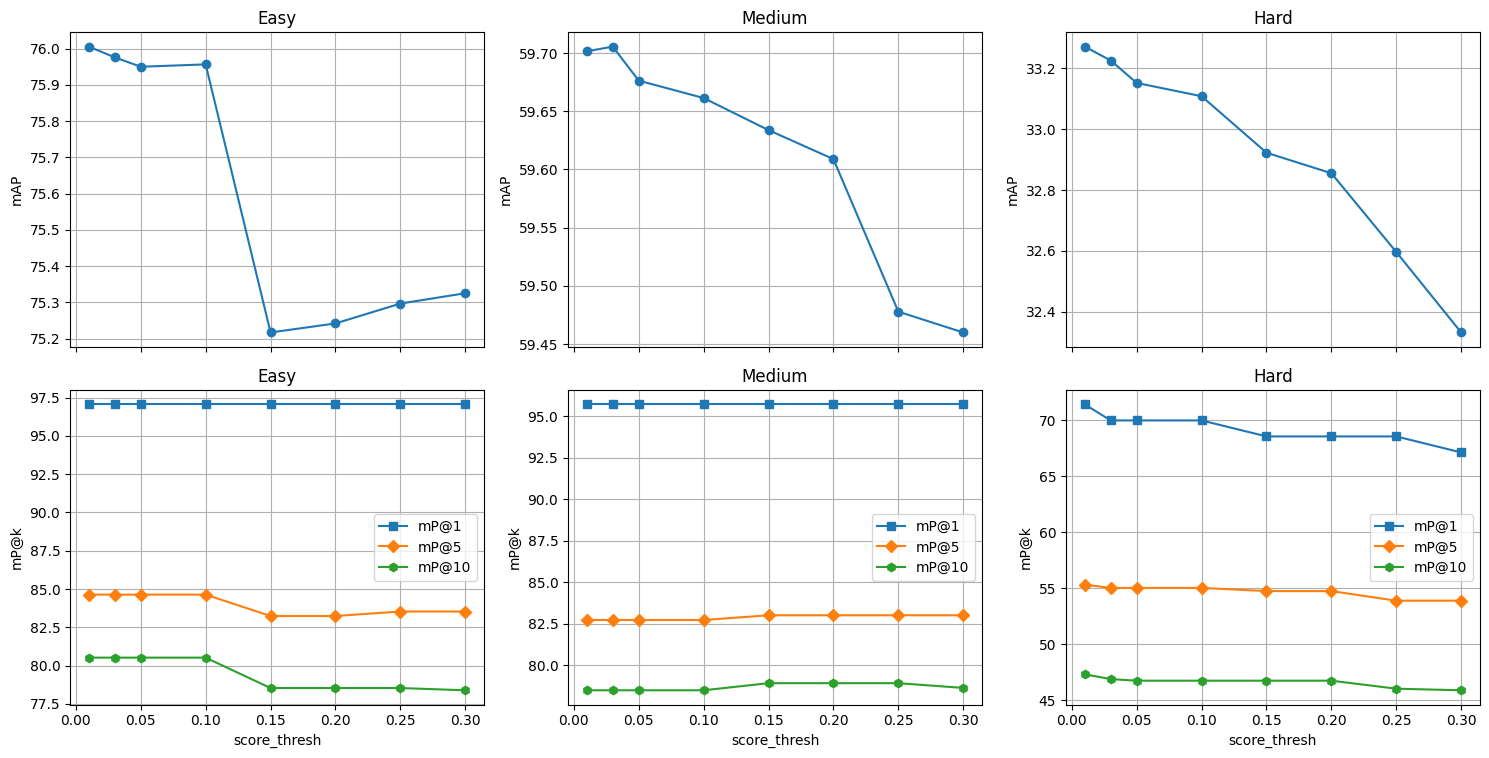

In [14]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox', 'map_easy_bbox', 'map_easy_bbox', 'Easy'),
    ('map_medium_bbox', 'map_medium_bbox', 'map_medium_bbox', 'Medium'),
    ('map_hard_bbox', 'map_hard_bbox', 'map_hard_bbox', 'Hard'),
    ('mp@1_easy_bbox', 'mp@5_easy_bbox', 'mp@10_easy_bbox', 'Easy'),
    ('mp@1_medium_bbox', 'mp@5_medium_bbox', 'mp@10_medium_bbox', 'Medium'),
    ('mp@1_hard_bbox', 'mp@5_hard_bbox', 'mp@10_hard_bbox', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=False)

for i, (ax, (col1, col2, col3, title)) in enumerate(zip(axs.flat, metrics)):
    ax.set_title(title)
    ax.set_xlabel('min_area')
    if i < 3:
        df_score_thresh.plot(x='score_thresh', y=col1, ax=ax, label='mAP', marker='o', legend=False)
        ax.set_ylabel('mAP')
    else:
        df_score_thresh.plot(x='score_thresh', y=col1, ax=ax, label='mP@1', marker='s', legend=False)
        df_score_thresh.plot(x='score_thresh', y=col2, ax=ax, label='mP@5', marker='D', legend=False)
        df_score_thresh.plot(x='score_thresh', y=col3, ax=ax, label='mP@10', marker='h', legend=False)
        ax.set_ylabel('mP@k')
        ax.legend()
    ax.grid(True)

# plt.suptitle('Area mínima para la base de datos', fontsize=16, y=1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('score_thresh_graph.png', dpi=300, bbox_inches='tight')
plt.show()

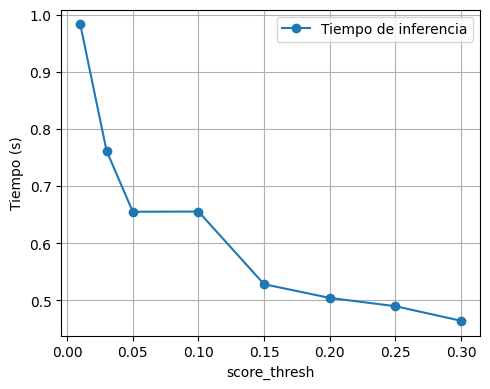

In [15]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(5, 4))  # Tamaño proporcional a cada subplot anterior

# Graficar tiempo de inferencia
df_score_thresh.plot(x='score_thresh', y='inference_time', ax=ax, marker='o', color='tab:blue', label='Tiempo de inferencia')

# Configurar ejes y estilo
ax.set_xlabel('score_thresh')
ax.set_ylabel('Tiempo (s)')
ax.grid(True)
ax.legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.savefig('score_thresh_time_graph.png', dpi=300, bbox_inches='tight')

plt.show()

In [22]:
# TEST iou_thresh
versions_ox = [38, 51, 52, 53, 54, 55, 56, 57, 58, 59]
df_iou_thresh_ox = df[df['version'].isin(versions_ox)]
df_iou_thresh_ox.sort_values('iou_thresh', inplace=True)

versions_pa = [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
df_iou_thresh_pa = df[df['version'].isin(versions_pa)]
df_iou_thresh_pa.sort_values('iou_thresh', inplace=True)

C:\Users\rdiaz\AppData\Local\Temp\ipykernel_21352\882739677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iou_thresh_ox.sort_values('iou_thresh', inplace=True)
C:\Users\rdiaz\AppData\Local\Temp\ipykernel_21352\882739677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iou_thresh_pa.sort_values('iou_thresh', inplace=True)


In [23]:
columns = [
    'version',
    'iou_thresh', 
    'map_easy_bbox', 'map_medium_bbox', 'map_hard_bbox', 
    'mp@1_easy_bbox', 'mp@1_medium_bbox', 'mp@1_hard_bbox', 
    'mp@5_easy_bbox', 'mp@5_medium_bbox', 'mp@5_hard_bbox', 
    'mp@10_easy_bbox', 'mp@10_medium_bbox', 'mp@10_hard_bbox',
    'inference_time'
]
df_iou_thresh_ox = df_iou_thresh_ox[columns]
df_iou_thresh_pa = df_iou_thresh_pa[columns]

In [24]:
df_iou_thresh = pd.merge(left=df_iou_thresh_ox, right=df_iou_thresh_pa, how='left', on='iou_thresh', suffixes = ['_ox', '_pa'])

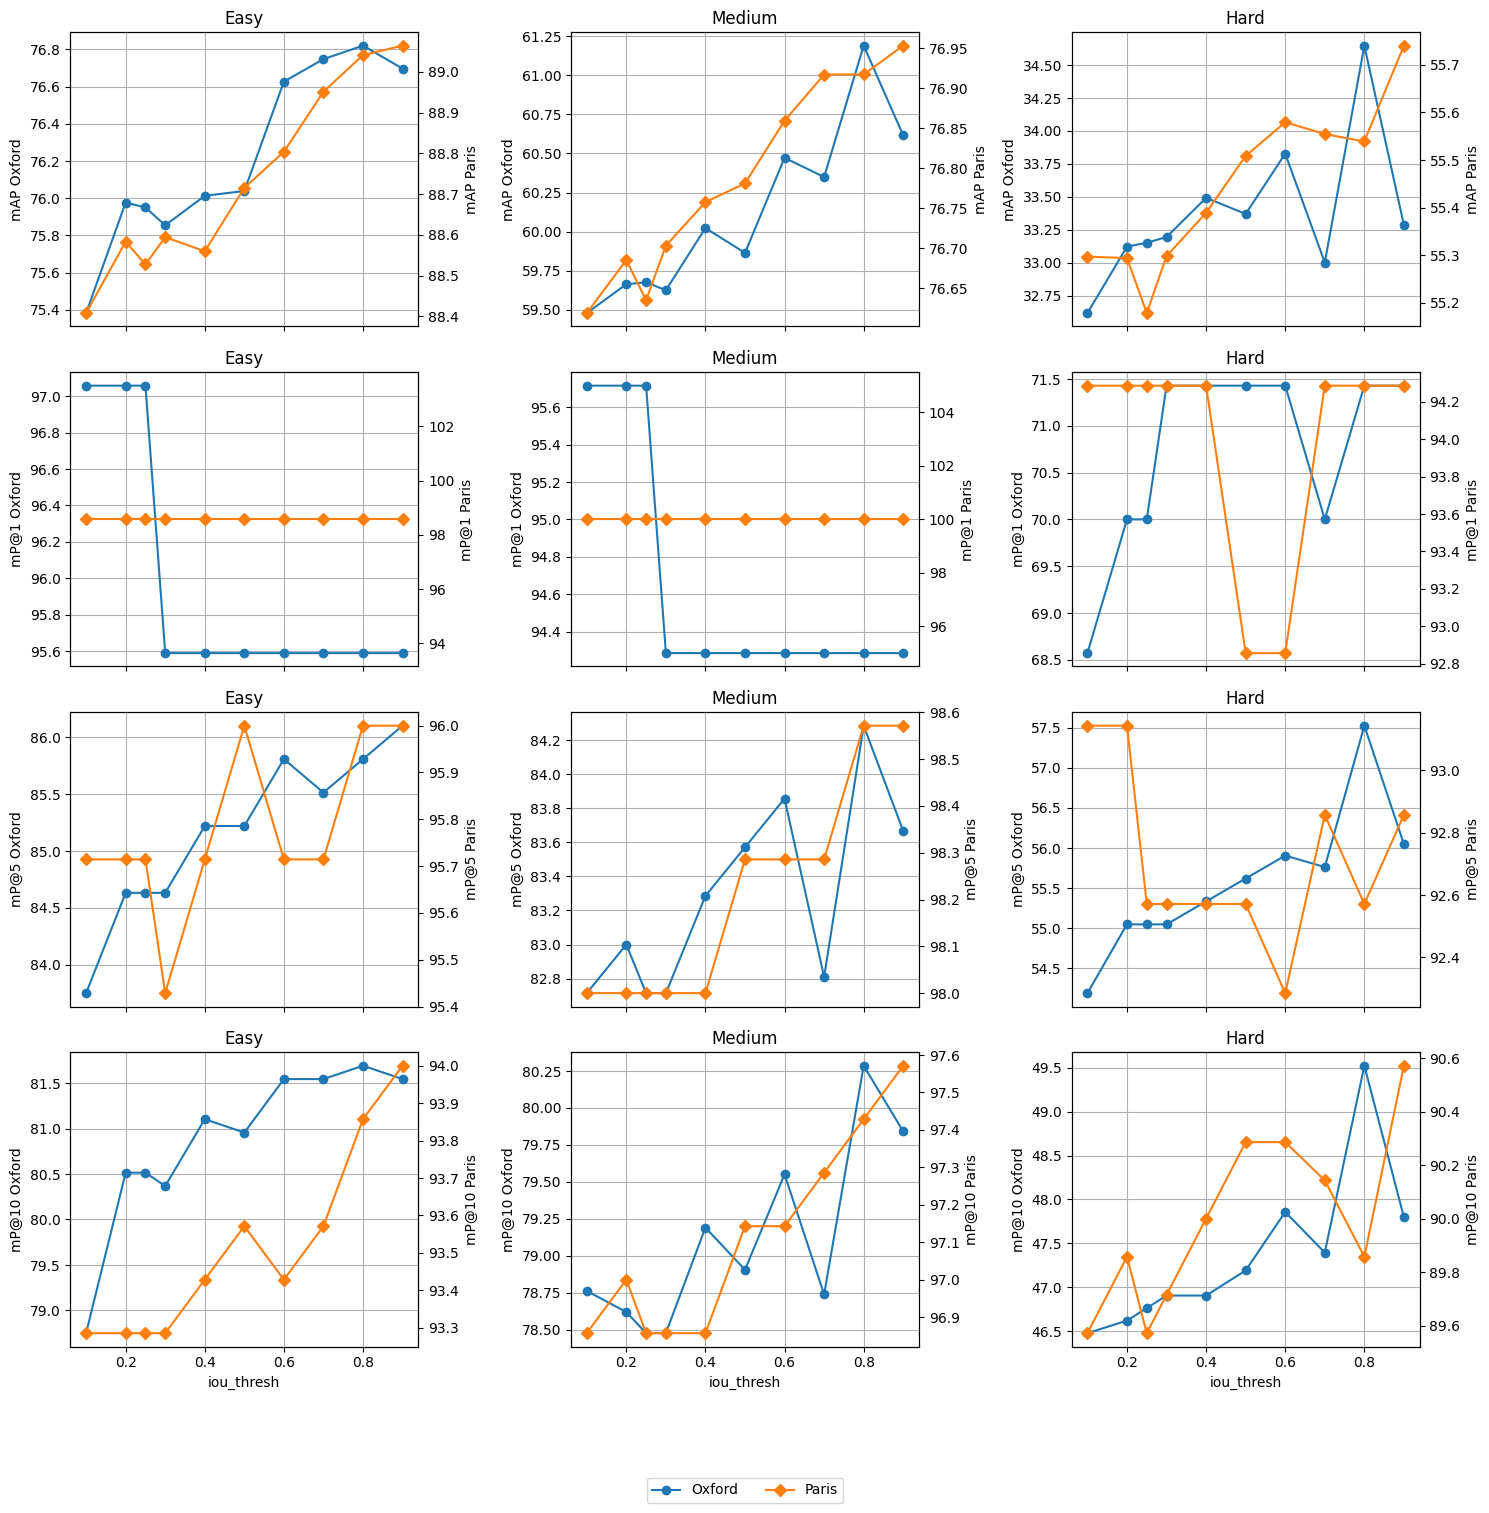

In [31]:
# Definir configuración de las métricas por nivel de dificultad
metrics = [
    ('map_easy_bbox_ox', 'map_easy_bbox_pa', 'Easy'),
    ('map_medium_bbox_ox', 'map_medium_bbox_pa', 'Medium'),
    ('map_hard_bbox_ox', 'map_hard_bbox_pa', 'Hard'),
    ('mp@1_easy_bbox_ox', 'mp@1_easy_bbox_pa', 'Easy'),
    ('mp@1_medium_bbox_ox', 'mp@1_medium_bbox_pa', 'Medium'),
    ('mp@1_hard_bbox_ox', 'mp@1_hard_bbox_pa', 'Hard'),
    ('mp@5_easy_bbox_ox', 'mp@5_easy_bbox_pa', 'Easy'),
    ('mp@5_medium_bbox_ox', 'mp@5_medium_bbox_pa', 'Medium'),
    ('mp@5_hard_bbox_ox', 'mp@5_hard_bbox_pa', 'Hard'),
    ('mp@10_easy_bbox_ox', 'mp@10_easy_bbox_pa', 'Easy'),
    ('mp@10_medium_bbox_ox', 'mp@10_medium_bbox_pa', 'Medium'),
    ('mp@10_hard_bbox_ox', 'mp@10_hard_bbox_pa', 'Hard'),
]

# Crear subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True, sharey=False)

# Para recolectar handles y labels de la leyenda
legend_handles = []
legend_labels = []
legend_added = False

for i, (ax, (col1, col2, title)) in enumerate(zip(axs.flat, metrics)):
    ax2 = ax.twinx()  # Crear segundo eje Y

    # Título y etiquetas
    ax.set_title(title)
    ax.set_xlabel('iou_thresh')

    # Elegir etiqueta Y según la métrica
    if i < 3:
        ylabel = 'mAP'
    elif i < 6:
        ylabel = 'mP@1'
    elif i < 9:
        ylabel = 'mP@5'
    else:
        ylabel = 'mP@10'

    ax.set_ylabel(f'{ylabel} Oxford')   # Eje izquierdo
    ax2.set_ylabel(f'{ylabel} Paris')   # Eje derecho

    # Graficar col1 en ax (izquierdo) y col2 en ax2 (derecho)
    line1 = df_iou_thresh.plot(x='iou_thresh', y=col1, ax=ax, label='Oxford', marker='o', color='tab:blue', legend=False)
    line2 = df_iou_thresh.plot(x='iou_thresh', y=col2, ax=ax2, label='Paris', marker='D', color='tab:orange', legend=False)

    # Capturar handles y labels solo una vez (suficiente con una instancia)
    if not legend_added:
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        legend_handles.extend(h1 + h2)
        legend_labels.extend(l1 + l2)
        legend_added = True

    # Agregar grilla al eje principal
    ax.grid(True)

# Colocar la leyenda una vez fuera del grid
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 0.99])
plt.savefig('iou_thresh_graph.png', dpi=300, bbox_inches='tight')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

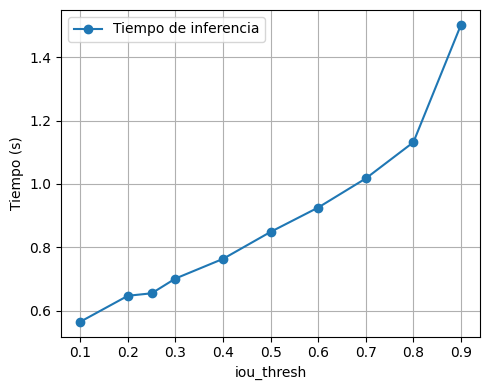

In [34]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(5, 4))  # Tamaño proporcional a cada subplot anterior

# Graficar tiempo de inferencia
df_iou_thresh.plot(x='iou_thresh', y='inference_time_ox', ax=ax, marker='o', color='tab:blue', label='Tiempo de inferencia')

# Configurar ejes y estilo
ax.set_xlabel('iou_thresh')
ax.set_ylabel('Tiempo (s)')
ax.grid(True)
ax.legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.savefig('iou_thresh_time_graph.png', dpi=300, bbox_inches='tight')

plt.show

In [ ]:
# TEST 
versions = [65]